# scRNA Seurat EDA

In [3]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(patchwork)
library(Matrix)
source("densmap.R")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: reticulate



In [135]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

In [136]:
day_config = read.table("../../figures_factory/configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

,day,colour
,<fct>,<chr>
D0,D0,#A61C24
D2,D2,#FF70A6
D4,D4,#D6E82F
D6,D6,#B14AED
D8,D8,#2D3142
D10,D10,#FC7753
D12,D12,#0AABB7
D14,D14,#336699


## Load Data

In [137]:
# aggregated cellranger data
rna.data = Read10X("/srv/scratch/surag/scRNA-reprog/filtered_feature_bc_matrix")

In [ ]:
rna = CreateSeuratObject(counts = rna.data, project = "scRNA-reprog", min.cells = 3, min.features = 200)

In [6]:
rna[["sample"]] = DAYS[as.numeric(lapply(strsplit(colnames(rna), "-"), "[[", 2))]

In [173]:
# mito frac
rna[["percent.mt"]] = PercentageFeatureSet(rna, pattern="^MT-")

In [61]:
table(rna@meta.data$sample)


   D0   D10   D12   D14    D2    D4    D6    D8 
11648 13280  9405 10154  3708  7082 11069  7562 

In [142]:
barcodes = as.character(read.table("./barcodes/20200831_nFeat200_mt15_oskm10_nCount2000_pk0.01.txt")$V1)

In [145]:
# remove QC fail barcodes
rna[['qc_pass']] = rownames(rna@meta.data) %in% barcodes
rna = subset(rna, subset = qc_pass==T)

In [147]:
ncol(rna)

[1] 59369

In [146]:
table(rna@meta.data$sample)


   D0   D10   D12   D14    D2    D4    D6    D8 
10326 11241  7743  7619  2618  5597  8363  5862 

## Select Subset

In [153]:
# md = rna@meta.data
# conds = md$nFeature_RNA > 200 & md$nFeature_RNA<5000 & md$percent.mt <10 & md$nCount_RNA > 2000
# sum(conds)
# table(md$sample[conds])

[1] 48471


  D0  D10  D12  D14   D2   D4   D6   D8 
9888 8930 5473 6334 2134 4214 6894 4604 

In [154]:
# equal_subselect = c()
# for (d in DAYS) {
#     equal_subselect = c(equal_subselect, sample(which(md$sample==d), 2000))
# #     equal_subselect = c(equal_subselect, sample(which(md$sample==d & conds), 2000))
# }

In [155]:
# conds = equal_subselect # c(subselect_D0, which(conds), subselect_D6, subselect_D8, subselect_D10)
# table(md$sample[conds])


  D0  D10  D12  D14   D2   D4   D6   D8 
2000 2000 2000 2000 2000 2000 2000 2000 

In [156]:
# select_bool = rep(0, ncol(rna))
# select_bool[conds] = 1
# rna[['selected']]= select_bool

In [868]:
# rna_subset = subset(rna, subset = selected==1)
rna_subset = subset(rna, subset = sample=="D2")
# rna_subset = rna # no further sub-selection, already QCed

In [869]:
table(rna_subset@meta.data$sample)


  D2 
2618 

In [870]:
sample(rownames(rna_subset@meta.data), 10)

[1] "GACACGCTCAAGAGGC-2" "TCAGTTTTCTGCAGCG-2" "GAGGGATAGAGGTCGT-2"
 [4] "CACCGTTAGCCATCCG-2" "AGTGATCTCGCGTGAC-2" "AGCTACACAGGTATGG-2"
 [7] "GGACGTCTCTTACACT-2" "CACGTTCCACTCAGAT-2" "CTCGAGGGTGACTCTA-2"
[10] "CACAGGCAGTAGGATT-2"

### Visualisation

In [872]:
rna_subset <- NormalizeData(rna_subset)
rna_subset <- FindVariableFeatures(rna_subset, selection.method = "vst", nfeatures = 2000)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”


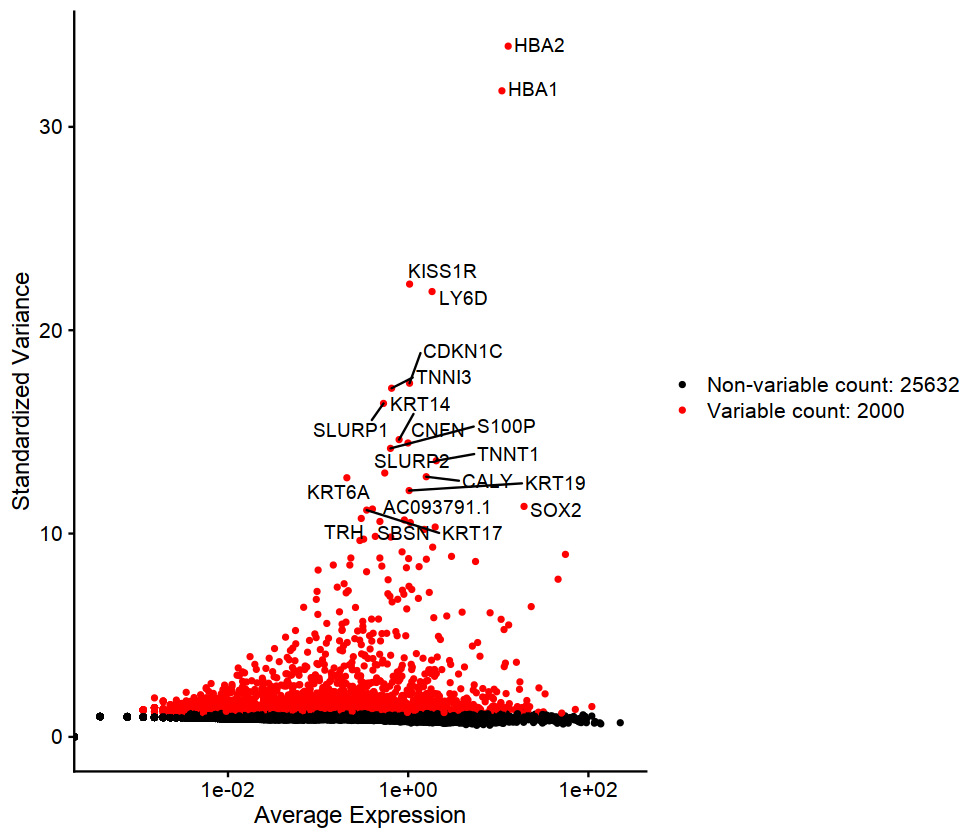

In [873]:
options(repr.plot.width = 8, repr.plot.height = 7)

# Identify the 10 most highly variable genes
topk <- head(VariableFeatures(rna_subset), 20)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(rna_subset)
plot2 <- LabelPoints(plot = plot1, points = topk, repel = T)
plot2

In [874]:
all.genes <- rownames(rna_subset)
rna_subset <- ScaleData(rna_subset, features = all.genes)

Centering and scaling data matrix



In [875]:
rna_subset <- RunPCA(rna_subset, features = VariableFeatures(object = rna_subset))

PC_ 1 
Positive:  H2AFZ, RPL22L1, MT2A, RPS17, COL3A1, SNHG29, THY1, CCDC85B, SNHG5, NCL 
	   RPL13A, PCLAF, DEK, PHLDA1, HSPD1, TYMS, FABP5, CENPW, RPL23, SRM 
	   SMC4, PA2G4, NOP56, TOMM5, CDKN3, CD44, CHN1, CKS2, HIST1H4C, MAD2L1 
Negative:  TNNT1, COL9A3, FBXO2, S100P, EEF1A2, FSTL3, HBA2, HBA1, PTP4A3, ARC 
	   TNNC1, ASCL2, CNFN, CALY, SCNN1D, PSTPIP1, KLK1, ADAM8, SBSN, KISS1R 
	   DMKN, HES4, RASGRP2, MLF1, TNNI3, MKNK2, NOXO1, CDH15, SOX15, SLC6A8 
PC_ 2 
Positive:  COL1A2, COL1A1, COL6A3, S100A13, FN1, MT2A, SPARC, CTHRC1, FTL, LGALS3 
	   IFI6, MALAT1, IFITM3, ZFP36L1, MYL9, TAGLN, DCN, ISG15, FOS, TGFBI 
	   TMEM158, C1R, ARID5B, MYLK, TUBA1A, IER3, IGFBP4, JUNB, CAMK2N1, PLAU 
Negative:  ODC1, UBE2S, CYCS, MYC, HSPD1, C1QBP, HSPE1, HSP90AB1, GTF2A2, DDX21 
	   POU5F1, GAL, SRM, FERMT1, LYAR, TOMM40, YBX3, SLIRP, CALM1, BZW2 
	   FKBP4, MRPL12, TOMM5, TUBB4B, HSPA8, FABP5, RFK, SOX2, CENPX, HSP90AA1 
PC_ 3 
Positive:  COMP, PLK5, TRH, ESPN, KISS1R, MAFA, MARCKSL1, COL11A2,

In [876]:
make_pc_plot <- function(seurat_object, pc_x, pc_y, legend=T) {
    plot_df <- data.frame(pc_x=data.frame(Embeddings(rna_subset, reduction='pca'))[,sprintf("PC_%d", pc_x)],
             pc_y=data.frame(Embeddings(rna_subset, reduction='pca'))[,sprintf("PC_%d", pc_y)],
             sample=rna_subset@meta.data$sample)
    plot_df = plot_df[sample(dim(plot_df)[1], 5000), ]

    p <- ggplot(plot_df) +
    geom_point(aes(x=pc_x, y=pc_y, color=factor(sample, levels=DAYS)), stroke=0, size=1) +
    theme_classic() +
    xlab(sprintf("PC_%d", pc_x)) + ylab(sprintf("PC_%d", pc_y)) +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    guides(colour = guide_legend(title="Day",
         override.aes = list(shape=16, alpha=1, size=4)))
    
    if (!legend) {
        p = p + theme(legend.position="none")
    }
    
    p
}

In [877]:
options(repr.plot.width = 12, repr.plot.height = 8)
make_pc_plot(rna_subset, 1 ,2)

ERROR: Error in sample.int(x, size, replace, prob): cannot take a sample larger than the population when 'replace = FALSE'


In [ ]:
pc_plots = list()

for (i in seq(1,10)) {
    pc_plots[[2*i-1]] = make_pc_plot(rna_subset, 2*i-1, 2*i, legend=F)
    pc_plots[[2*i]] = make_pc_plot(rna_subset, 2*i, 2*i+1, legend=F)
}

In [ ]:
options(repr.plot.width = 24, repr.plot.height = 8)

wrap_plots(pc_plots, nrow=2)

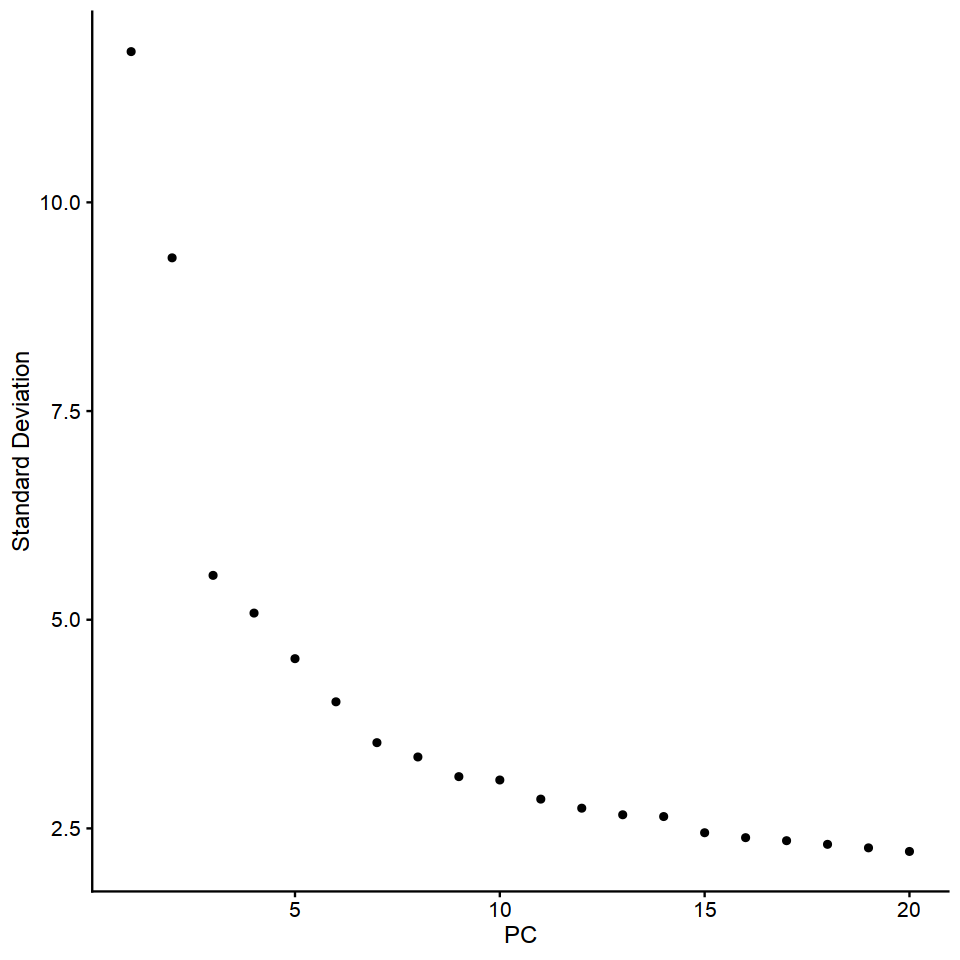

In [878]:
options(repr.plot.width = 8, repr.plot.height = 8)

ElbowPlot(rna_subset)

In [879]:
rna_subset <- RunUMAP(rna_subset, dims = 1:8, seed.use = 1)

11:15:53 UMAP embedding parameters a = 0.9922 b = 1.112

11:15:53 Read 2618 rows and found 8 numeric columns

11:15:53 Using Annoy for neighbor search, n_neighbors = 30

11:15:53 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

11:15:56 Writing NN index file to temp file /tmp/RtmplWFoxU/file8086385f4dbd

11:15:56 Searching Annoy index using 1 thread, search_k = 3000

11:16:00 Annoy recall = 100%

11:16:06 Commencing smooth kNN distance calibration using 1 thread

11:16:11 Initializing from normalized Laplacian + noise

11:16:11 Commencing optimization for 500 epochs, with 102064 positive edges

11:16:23 Optimization finished



In [880]:
densmap <- densMAP(as.matrix(Embeddings(rna_subset, reduction='pca'))[,1:8], 
                   n_neighbors=30, metric='cosine', dens_frac=0.2, dens_lambda=0.5, final_dens=F)

In [881]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_subset, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_subset, reduction='umap'))$UMAP_2,
                 sample=rna_subset@meta.data$sample)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_day <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=factor(sample, levels=DAYS)), stroke=0, size=1) +
theme_classic() +
scale_color_manual(values=day_config$colour) +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4))) + 
coord_fixed()

In [882]:
plot_df <- data.frame(pc1=densmap[,1],
                 pc2=densmap[,2],
                 sample=rna_subset@meta.data$sample)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_day_densmap <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=factor(sample, levels=DAYS)), stroke=0, size=1) +
theme_classic() +
scale_color_manual(values=day_config$colour) +
xlab("DENSMAP 1") + ylab("DENSMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4))) +
coord_fixed()

In [883]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_subset, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_subset, reduction='umap'))$UMAP_2,
                 depth=log10(rna_subset@meta.data$nCount_RNA))
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_depth <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(depth))) +
geom_point(stroke=0, size=1) +
theme_classic() +
scale_color_viridis_c() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
coord_fixed()

In [884]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_subset, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_subset, reduction='umap'))$UMAP_2,
                 mt=rna_subset@meta.data$percent.mt)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_mt <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(mt))) +
geom_point(stroke=0, size=1) +
theme_classic() +
scale_color_viridis_c() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
coord_fixed()

In [885]:
head(plot_df)

,pc1,pc2,mt
,<dbl>,<dbl>,<dbl>
726,-1.2444118,3.9757322,4.657035
2143,3.4425665,5.5071081,5.918006
2368,0.2917476,-0.1034025,8.534780
768,2.0516666,3.4946856,4.547858
1981,-4.8761884,-5.4427670,5.607683
180,3.3519414,-1.4138395,5.217666


In [886]:
sum((rna_subset@assays$RNA["POU5F1"]>0)&(rna_subset@assays$RNA["KLF4"]>0)&(rna_subset@assays$RNA["SOX2"]>0)&(rna_subset@assays$RNA["MYC"]>0))

[1] 1809

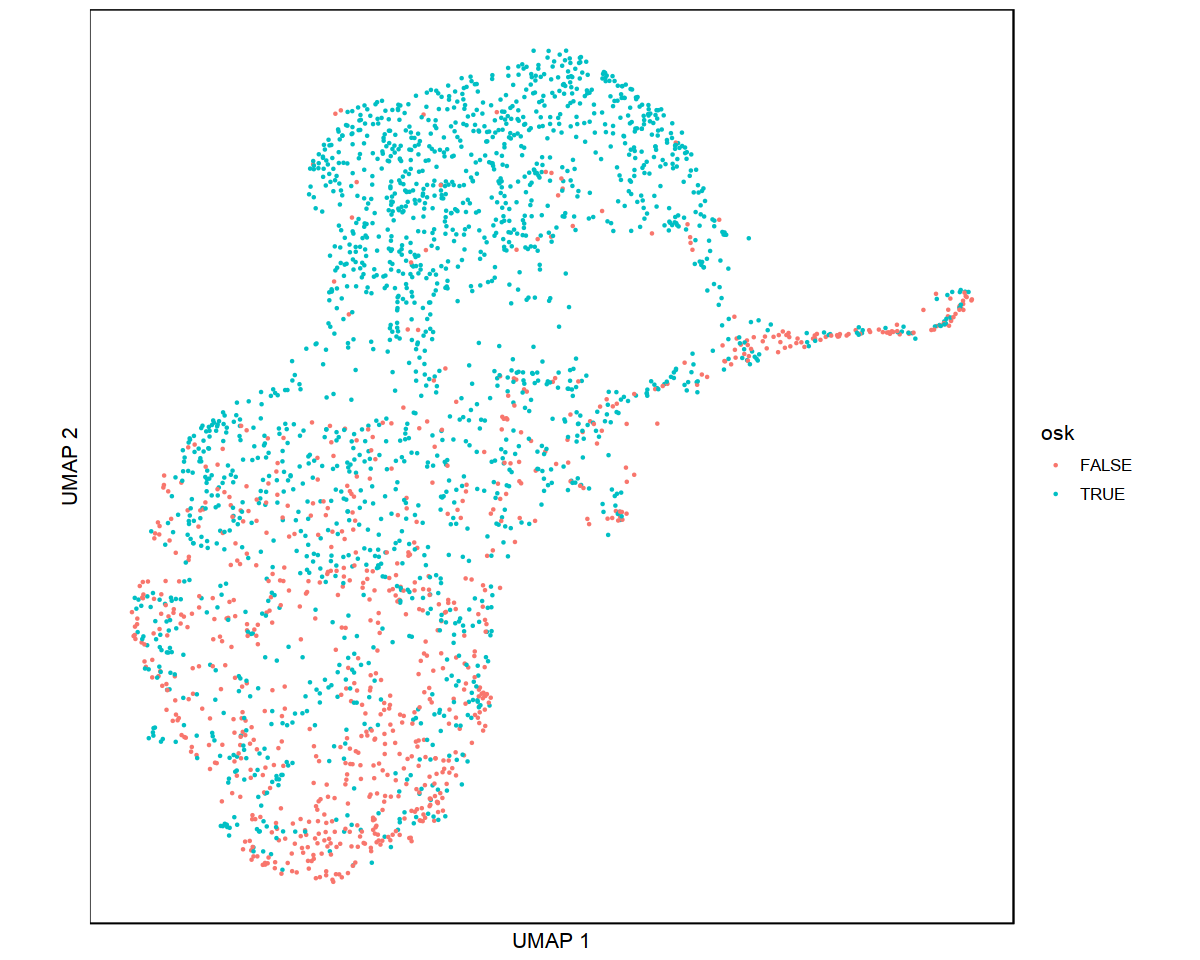

In [887]:
options(repr.plot.width = 10, repr.plot.height = 8)

plot_df <- data.frame(pc1=data.frame(Embeddings(rna_subset, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_subset, reduction='umap'))$UMAP_2,
                 osk=as.vector((rna_subset@assays$RNA["POU5F1"]>0)&
                               (rna_subset@assays$RNA["KLF4"]>0)&
                               (rna_subset@assays$RNA["SOX2"]>0)&
                               (rna_subset@assays$RNA["MYC"]>0)))
plot_df = plot_df[sample(dim(plot_df)[1]), ]

ggplot(plot_df, aes(x=pc1, y=pc2, col=osk)) +
geom_point(stroke=0, size=1) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
coord_fixed()

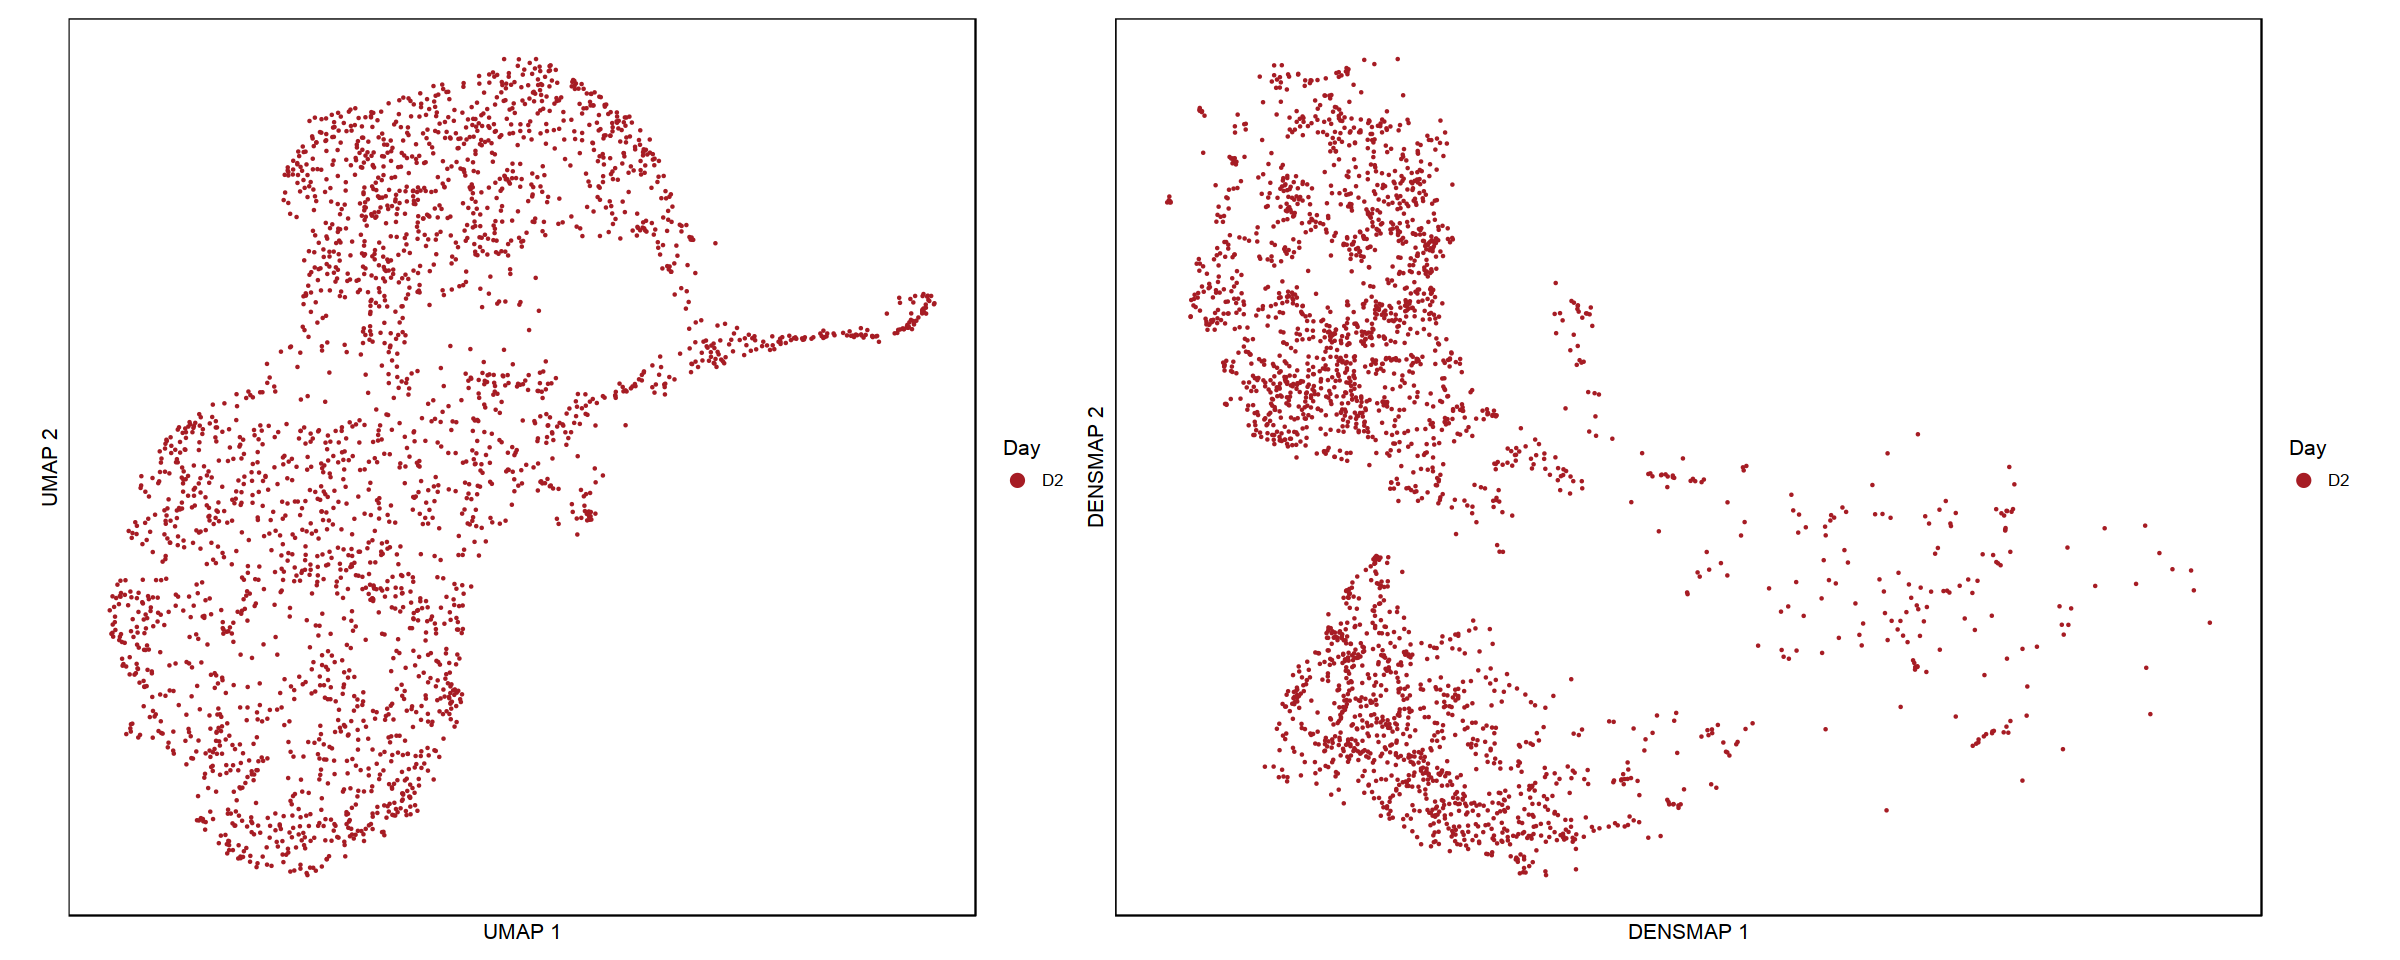

In [888]:
options(repr.plot.width = 20, repr.plot.height = 8)

by_day | by_day_densmap

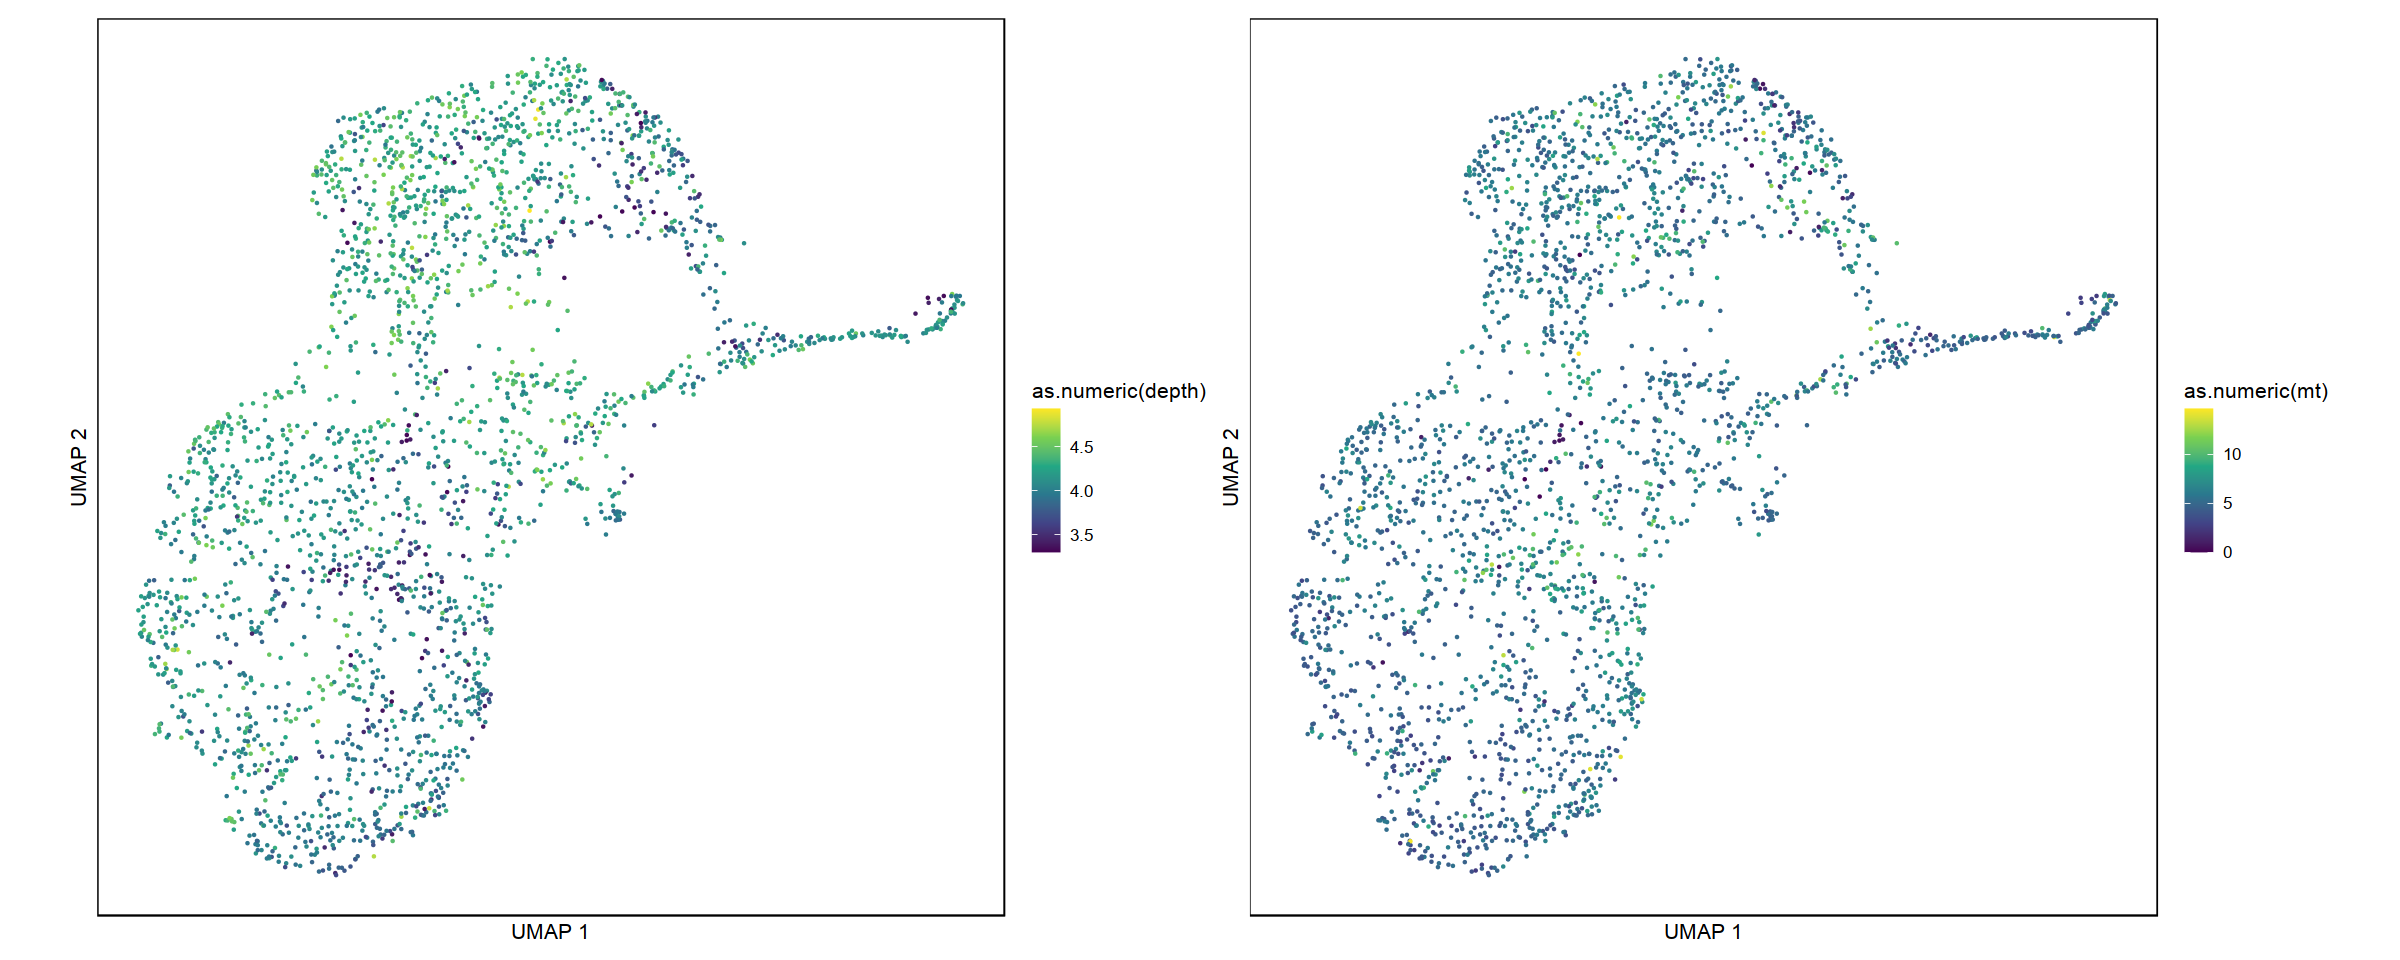

In [889]:
options(repr.plot.width = 20, repr.plot.height = 8)

by_depth | by_mt

### Clusters

In [890]:
rna_subset <- FindNeighbors(rna_subset, dims = 1:8)
rna_subset <- FindClusters(rna_subset, resolution = .5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2618
Number of edges: 79255

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8464
Number of communities: 8
Elapsed time: 0 seconds


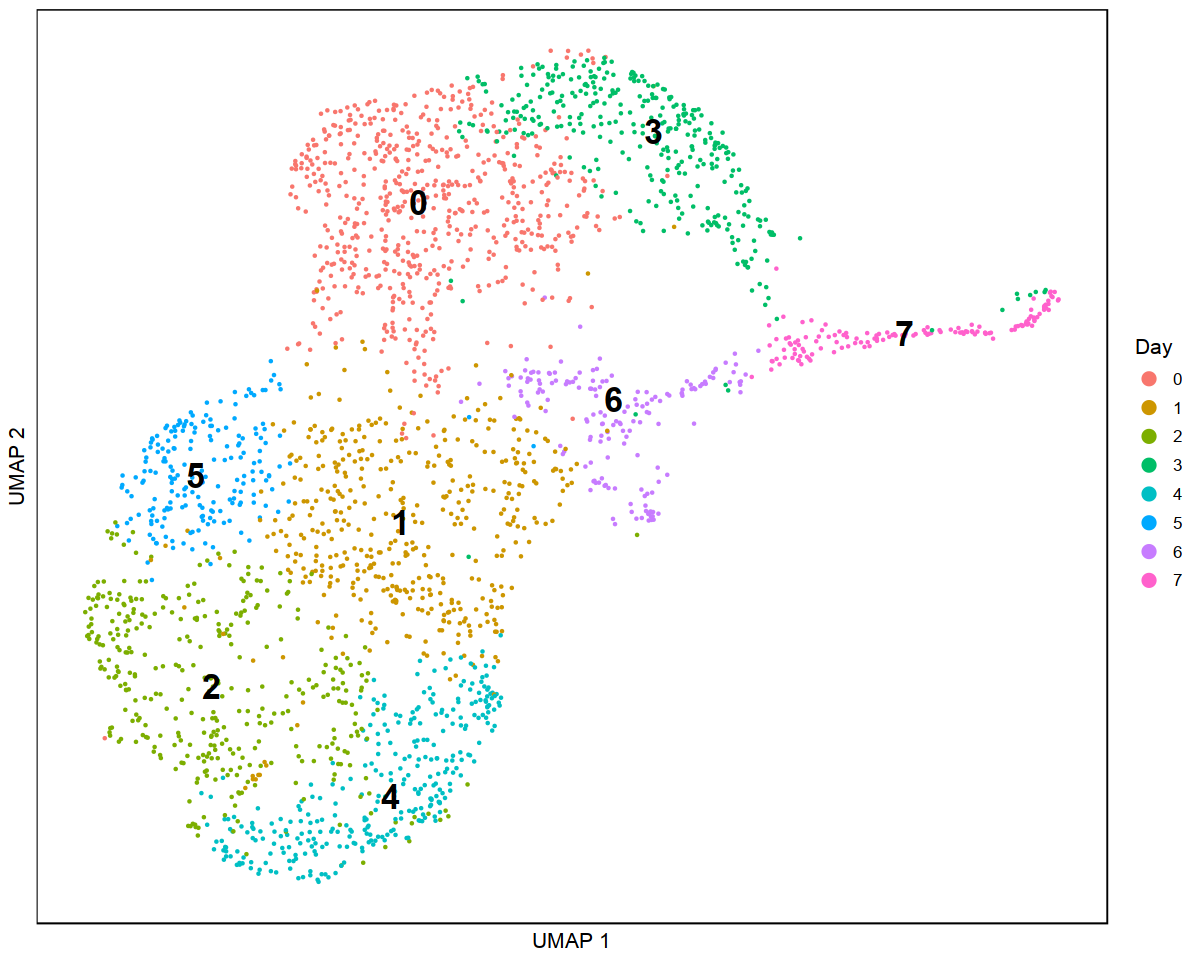

In [891]:
options(repr.plot.width = 10, repr.plot.height = 8)

plot_df <- data.frame(umap1=data.frame(Embeddings(rna_subset, reduction='umap'))$UMAP_1,
                 umap2=data.frame(Embeddings(rna_subset, reduction='umap'))$UMAP_2,
                 cluster=rna_subset@meta.data$seurat_clusters)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

ggplot(plot_df) +
geom_point(aes(x=umap1, y=umap2, color=cluster), stroke=0, size=1) +
geom_text(data=data.frame(aggregate(plot_df[,c("umap1","umap2")], 
                            list(plot_df$cluster), median)),
         aes(x=umap1, y=umap2, label=Group.1), fontface = "bold", size=7) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

In [269]:
cluster_markers = FindMarkers(rna_subset, only.pos = T, ident.1 = 10, test.use = "roc", min.pct = 0.1)
# cluster_markers = cluster_markers[rev(order(cluster_markers$avg_logFC)), ]

In [270]:
head(cluster_markers, 10)

,myAUC,avg_diff,power,pct.1,pct.2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
APOE,0.978,2.0147276,0.956,1.000,0.389
NLRP7,0.963,1.6266133,0.926,0.977,0.110
TDGF1,0.957,1.4821668,0.914,0.990,0.157
MT1H,0.947,1.9694002,0.894,0.986,0.249
RPS3,0.946,0.6107565,0.892,1.000,1.000
UTF1,0.945,1.4361863,0.890,0.997,0.275
SPINT2,0.941,1.2701897,0.882,0.989,0.268
EPCAM,0.937,1.1933726,0.874,0.956,0.144
UGP2,0.936,1.1394211,0.872,0.994,0.666


In [271]:
dim(cluster_markers[cluster_markers$pct.2 < .25, ])
head(cluster_markers[cluster_markers$pct.2 < .25, ], 20)

[1] 196   5

,myAUC,avg_diff,power,pct.1,pct.2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NLRP7,0.963,1.6266133,0.926,0.977,0.110
TDGF1,0.957,1.4821668,0.914,0.990,0.157
MT1H,0.947,1.9694002,0.894,0.986,0.249
EPCAM,0.937,1.1933726,0.874,0.956,0.144
MT1F,0.936,1.0783691,0.872,0.948,0.140
LINC01356,0.931,1.6640136,0.862,0.878,0.035
NLRP2,0.927,1.0485206,0.854,0.903,0.079
DNMT3B,0.924,1.0415467,0.848,0.892,0.093
NODAL,0.913,0.9900009,0.826,0.903,0.096


In [216]:
# contrast
contrast_markers = FindMarkers(rna_subset, only.pos = T, ident.1 = 3, ident.2 = 2,test.use = "roc", min.pct = 0.25)
dim(contrast_markers)

[1] 112   5

In [217]:
head(contrast_markers)

,myAUC,avg_diff,power,pct.1,pct.2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
POU5F1,0.863,1.1975274,0.726,0.998,0.994
SOX2,0.829,1.0174403,0.658,0.996,0.942
KLF4,0.780,0.8843289,0.560,0.988,0.956
TUBB4B,0.755,0.5216154,0.510,0.988,0.978
CMTM6,0.737,0.5117319,0.474,0.902,0.761
TUBB2A,0.730,0.5588292,0.460,0.868,0.682


In [212]:
dim(contrast_markers[contrast_markers$pct.2 < .5, ])
head(contrast_markers[contrast_markers$pct.2 < .5, ], 20)

[1] 129   5

,myAUC,avg_diff,power,pct.1,pct.2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MIR302CHG,0.855,1.1845718,0.710,0.750,0.067
CALB1,0.854,1.1301620,0.708,0.754,0.065
CHST2,0.852,0.7993104,0.704,0.833,0.165
GAL,0.818,0.7498367,0.636,0.948,0.464
PLAAT3,0.817,0.7816177,0.634,0.756,0.190
LINC02582,0.812,0.6576993,0.624,0.661,0.044
CD36,0.804,0.7357757,0.608,0.640,0.037
CD24,0.803,1.0376256,0.606,0.648,0.054
KRT18,0.798,1.0673251,0.596,0.869,0.484


In [213]:
write.table(rownames(contrast_markers[contrast_markers$pct.2 < .5, ]), 
            file="tmp.txt", row.names=F, quote=F, col.names=F)

In [90]:
markers <- FindAllMarkers(rna_subset, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



In [140]:
cur_markers = markers %>% filter(cluster==3) %>% arrange(-avg_logFC)
dim(cur_markers)
head(cur_markers, 20)

[1] 474   7

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,0.000000e+00,1.1945482,0.873,0.477,0.000000e+00,3,GLUL
2,0.000000e+00,1.0472016,0.494,0.072,0.000000e+00,3,LINC00437
3,0.000000e+00,1.0195047,0.961,0.664,0.000000e+00,3,ODC1
4,0.000000e+00,0.9529389,0.961,0.569,0.000000e+00,3,MYC
5,0.000000e+00,0.8881846,0.458,0.082,0.000000e+00,3,AZGP1
6,0.000000e+00,0.8772564,0.993,0.795,0.000000e+00,3,UBE2S
7,0.000000e+00,0.8112351,0.980,0.838,0.000000e+00,3,GTF2A2
8,1.187619e-262,0.7852615,0.716,0.296,3.281630e-258,3,TFB1M
9,0.000000e+00,0.7821813,0.996,0.952,0.000000e+00,3,CALM1


In [141]:
write.table(cur_markers$gene, 
            file="tmp.txt", row.names=F, quote=F, col.names=F)

## Gene Plots

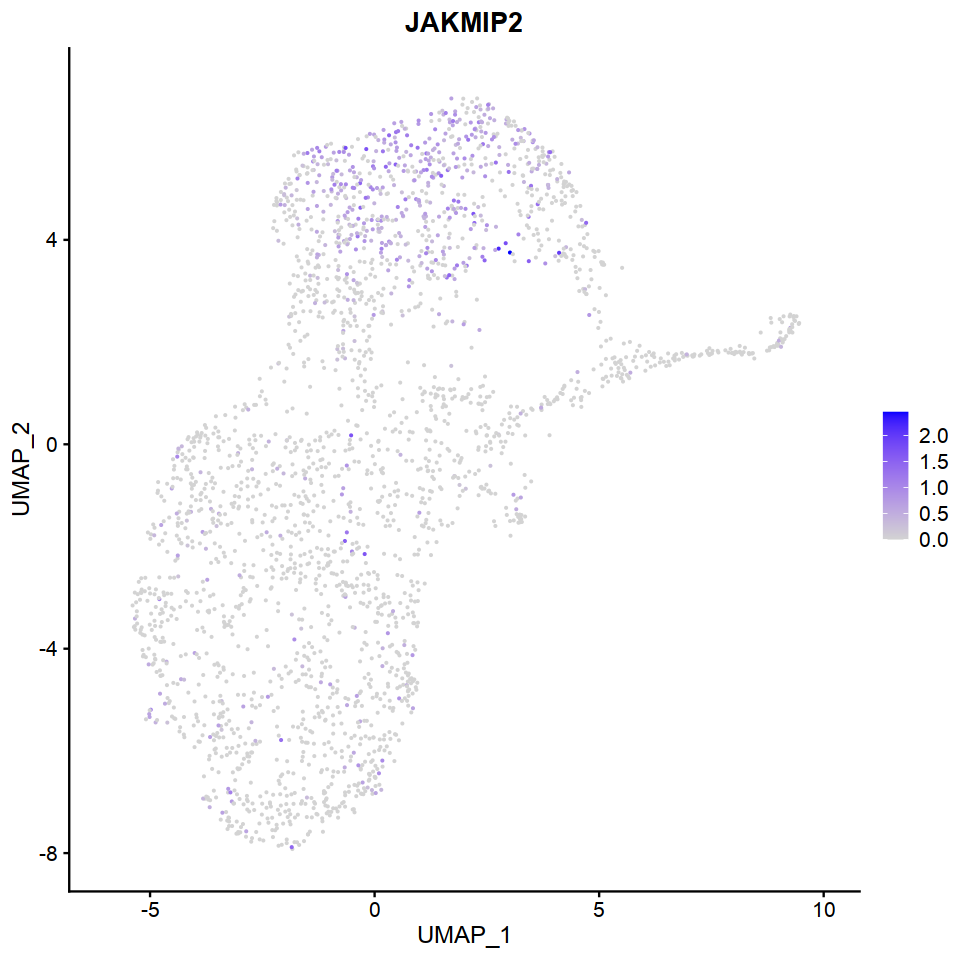

In [978]:
options(repr.plot.width = 8, repr.plot.height = 8)

FeaturePlot(rna_subset, features = c("JAKMIP2"), reduction = "umap", pt.size = 0.1, combine = FALSE)[[1]]

In [ ]:
options(repr.plot.width = 24, repr.plot.height = 16)
# iPSC genes
plots = FeaturePlot(rna_subset, features = c("NANOG", "UTF1", "DPPA4", "LIN28A", "CDH1", "DNMT3B" ), reduction = "umap", pt.size = 0.1, combine = FALSE)
wrap_plots(plots, nrow=2)

In [ ]:
options(repr.plot.width = 24, repr.plot.height = 8)
# fibroblast genes
plots = FeaturePlot(rna_subset, features = c("COL1A1", "MMP2", "FN1"), reduction = "umap", pt.size = 0.1, combine = FALSE)
wrap_plots(plots, nrow=1)

In [ ]:
options(repr.plot.width = 24, repr.plot.height = 8)
# KLF4 target genes
plots = FeaturePlot(rna_subset, features = c("HBA1", "KRT14", "LGALS7"), reduction = "umap", pt.size = 0.1, combine = FALSE)
wrap_plots(plots, nrow=1)

In [ ]:
options(repr.plot.width = 24, repr.plot.height = 8)
# viral response
plots = FeaturePlot(rna_subset, features = c("OAS1", "OAS2", "OAS3"), reduction = "umap", pt.size = 0.1, combine = FALSE)
wrap_plots(plots, nrow=1)

In [ ]:
options(repr.plot.width = 24, repr.plot.height = 8)
# metallothioneins
plots = FeaturePlot(rna_subset, features = c("MT1X", "MT1G", "MT1F"), reduction = "umap", pt.size = 0.1, combine = FALSE)
wrap_plots(plots, nrow=1)

In [ ]:
options(repr.plot.width = 24, repr.plot.height = 8)

# cell cycle factors
plots = FeaturePlot(rna_subset, features = c("UBE2C", "TOP2A", "CDK1"), reduction = "umap", pt.size = 0.1, combine = FALSE)
wrap_plots(plots, nrow=1)

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 16)

# OSKM
plots = FeaturePlot(rna_subset, features = c("POU5F1", "SOX2", "KLF4", "MYC"), reduction = "umap", pt.size = 0.1, combine = FALSE)
wrap_plots(plots, nrow=2)

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 16)

plots = FeaturePlot(rna_subset, features = c("MAP2", "JAKMIP2", "KLK11", "KRT14"), reduction = "umap", pt.size = 0.1, combine = FALSE)
wrap_plots(plots, nrow=2)

## Save RDS

In [680]:
dim(rna_subset)

[1] 27632 59369

In [681]:
saveRDS(rna_subset, file=sprintf("./sessions/20200913_n%d.rds", dim(rna_subset)[1]))

---

In [77]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] optparse_1.6.6  reticulate_1.15 patchwork_1.0.0 ggplot2_3.3.0  
[5] dplyr_0.8.5     Seurat_3.1.5   

loaded via a namespace (and not attached):
 [1] tsne_0.1-3          nlme_3.1-147        bitops_1.0-6       
 [4] RcppAnnoy_0.0.16    RColorBrewer_1.1-2  httr_1.4.1         
 [7] repr_1.1.0      